#Fraud Detection using semi supervised learning


In [ ]:

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)


In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/My Drive/fraud/creditcard.csv")
data["Time"] = data["Time"].apply(lambda x: x / 3600 % 24)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


the dataset consists of 28 anonymized variables, 1 "amount" variable, 1 "time" variable and 1 target variable -Class. Let's look at the distribution of target

In [ ]:
vc = data['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].astype(float).apply(lambda x: round(100*x / len(data), 4))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Count,count,percent
0,0,284315,0.0000
1,1,492,0.0004


one of the biggest challenge of this problem is that the target is highly imbalanced as only 0.17% cases are fraud transactions. But the advantafe of the representation learning is that it is still able to handle such imbalance nature of the problems. We will look how. For our use-case let's take only about 1000 rows of non-fraud transactions

In [ ]:
#Consider only 1000 rows of non fraud cases
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

df = pd.concat([non_fraud, fraud]).sample(frac=1).reset_index(drop=True)
X= df.drop(['Class'], axis = 1).values
Y = df["Class"].values

#Visualize Fraud and NonFraud transactions

- Let's visualize the nature of fraud and non-fraud transactions using R-SNE (t- distributed stochastic neighbor embedding) is a dataset decomposition technique which reduced the dimensions of data and produces only top n components with maximum information

- every dot in the following represents a transaction. Non fraud transactions are represented as Green while Fraud transactions are represented as red. The two axis are the components extracted by tsne

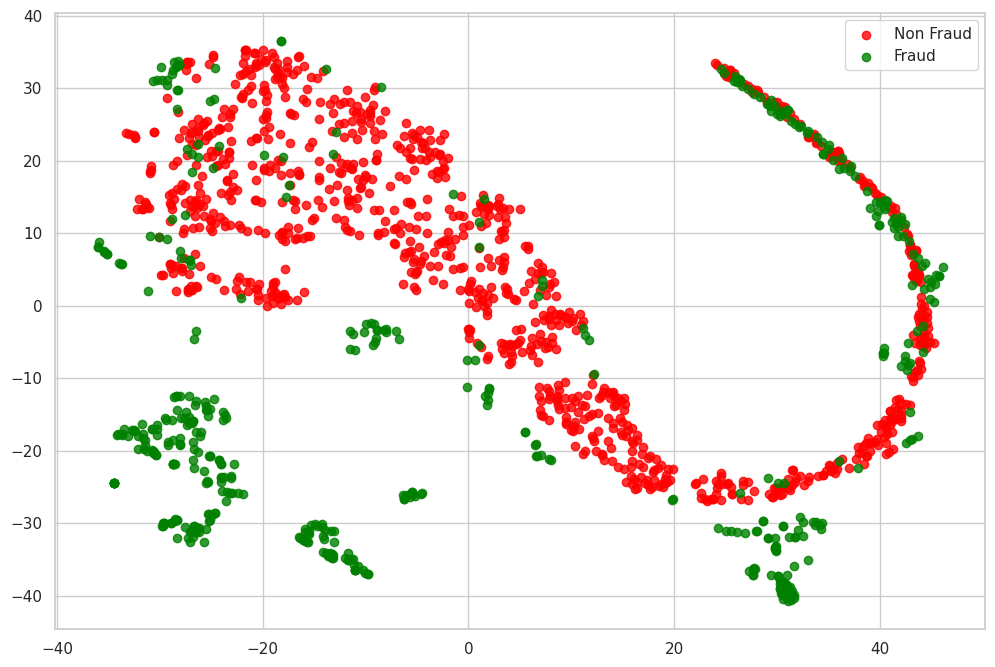

In [ ]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='red', linewidths=1, alpha=0.8, label='Non Fraud') # Changed label to Non Fraud and updated linewidths to avoid TypeError
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='green', linewidths=1, alpha=0.8, label='Fraud') # Added scatter plot for Fraud data points with color='green'

    plt.legend(loc='best')
    plt.savefig(name)
    plt.show()

tsne_plot(X, Y, "original.png")

From the above graph we can observe that there are many non-fraud transactions which are very close to fraud transactions, thus are difficult to accurately classify from a model.


# AutoEncoders to the rescue

- Autoencoders are a special type of neural network architectures in which the output is same as the input. Autoencoders are trained in an unsupervised manner in order to learn the extremely low level representations of the input data. These low level features are then deformed back to project the  actual data. An autoencoder is a regression task where the network is asked to predict its input (in other words, model the identity function). These networks has a tight bottleneck of a few neurons in the middle, forcing them to create effective representations that compress the input into a low-dimensional code that can be used by the decoder to reproduce the original input.

- We will create an autoencoder model in which we only show the model non-fraud cases. The model will try to learn the best representation of non-fraud cases. The same model will be used to generate the representations of fraud cases and we expect them to be different from non-fraud ones.

- Create a network with one input layer and one output layer having identical dimensions ie. the shape of non-fraud cases. We will use keras package

In [ ]:
#input layer
input_layer = Input(shape=(X.shape[1],))

#Encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation = 'relu')(encoded)

#Decoding part
decoded= Dense(50, activation= 'tanh')(encoded)
decoded = Dense(50, activation= 'tanh')(decoded)

#output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

create the model architecture by compiling input layer and output layers. Also add the optimizer and loss function, i am using "adadelta" as the optimizer and "mse" as the loss function


In [ ]:
autoencoder= Model(input_layer, output_layer)
autoencoder.compile(optimizer='adadelta', loss='mse')

In [ ]:
#before training let's perform min max scaling
x = data.drop(["Class"], axis=1)
y= data["Class"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y== 0], x_scale[y==1]




The beauty of this approach is that we do not need too many samples of data for learning the good representations. We will use only 2000 rows of non fraud cases to train the autoencoder. Additionally, we dont need to run this model for a large number of epochs.

Explanation: The choice of small samples from the original dataset is based on the intuition that one class characteristics (non fraud) will differ from that of the other (fraud).
To distinguish these characteristics we need to show the autoencoders only one class of data. This is because the autoencoder will try to learn only one class and automatically distinguish the other class

In [ ]:
autoencoder.fit(x_norm[0:2000], x_norm[0:2000],
                batch_size = 256, epochs = 10,
                shuffle = True, validation_split = 0.20);

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 1.0072 - val_loss: 0.8940
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0071 - val_loss: 0.8935
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0065 - val_loss: 0.8931
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0059 - val_loss: 0.8926
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.0052 - val_loss: 0.8921
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.0048 - val_loss: 0.8916
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0043 - val_loss: 0.8912
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.0041 - val_loss: 0.8907
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0035 - val_loss: 0.8902
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0027 - val_loss: 0.8897


#obtain the latent representations
Now, the model is trained. We are interested in obtaining latent representation of the input learned by the model. This can be accessed by the weights of the trained model. We will create another network containing sequential layers, and we will only add the trained weights till the third layer where latent representation exists.

In [ ]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

Generate the hidden representations of two classes: non-fraud and fraud by predicting the raw inputs using the above model.

In [ ]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


#visualize the latent representations: fraud vs non fraud
now we will create a dataset using the latent representations obtained and let's visualize the nature of fraud vs non fraud cases.

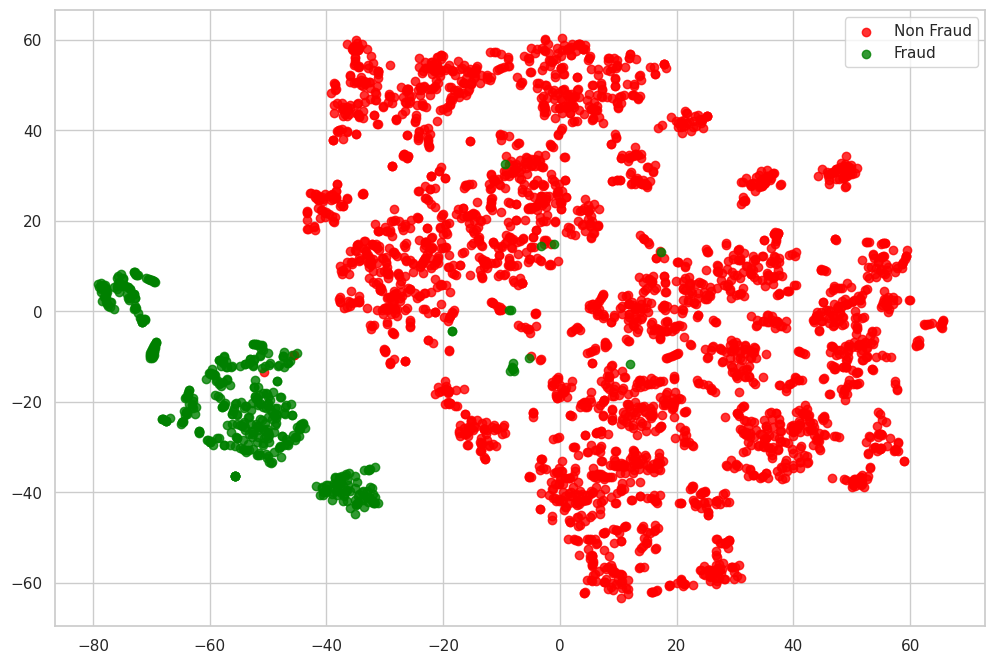

In [ ]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")

what a perfect graph, we can observe that now fraud and non-fraud transactions are pretty visible and are linearly separable. Now we dont need any complex model to classify this, even the simples models can be used to predict. Here is the before and after view of Fraud and Non Fraud transactions

In [ ]:
from IPython.display import display, Image, HTML
display(HTML("""<table align="center">
<tr ><td><b>Actual Representation (Before) </b></td><td><b>Latent Representation (Actual)</b></td></tr>
<tr><td><img src='original.png'></td><td>
             <img src='latent_representation.png'></td></tr></table>"""))


Actual Representation (Before),Latent Representation (Actual)
,


In [ ]:
#Simple Linear Classifier
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print("")
print(" Classification report:")
print(classification_report(val_y, pred_y))
print("")
print("Accuracy Score ", accuracy_score(val_y, pred_y))


 Classification report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       742
         1.0       0.99      0.89      0.94       131

    accuracy                           0.98       873
   macro avg       0.99      0.95      0.96       873
weighted avg       0.98      0.98      0.98       873


Accuracy Score  0.9828178694158075


#Applying to a different dataset: Titanic
Let's apply this approach to another dataset. I will use the popular titanic dataset fort this purpose

In [ ]:
train = pd.read_csv("/content/drive/My Drive/titanic/train.csv")
test = pd.read_csv("/content/drive/My Drive/titanic/test.csv")

In [ ]:
import re
full_data = [train, test]

train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

for dataset in full_data:
  dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in full_data:
  dataset['IsAlone'] = 0
  dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)

    # Using .loc to avoid chained assignment:
    dataset.loc[dataset['Age'].isnull(), 'Age'] = age_null_random_list

    dataset['Age'] = dataset['Age'].astype(int)

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']         = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2




In [ ]:
#Define autoencoder model
X= train.drop(["Survived"], axis = 1)
y = train["Survived"]
y = y.values

##Define the model
input_layer= Input(shape= (X.shape[1],))
encoded = Dense(100, activation = 'tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(50, activation='tanh')(encoded)
output_layer =  Dense(X.shape[1], activation = 'relu')(decoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adadelta', loss='mse')

In [ ]:
X = X.drop(columns=["Ticket", "Cabin"])



KeyError: "['Ticket', 'Cabin'] not found in axis"

In [ ]:
X = X.drop(columns=["CategoricalFare"])

In [ ]:
X.head(1)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,Title
0,1,3,1,22,1,0,0.0,0,23,0,2,0,"(-0.001, 7.91]",1


In [ ]:
print(X.dtypes)


PassengerId           int64
Pclass                int64
Sex                   int64
Age                   int64
SibSp                 int64
Parch                 int64
Fare                float64
Embarked              int64
Name_length           int64
Has_Cabin             int64
FamilySize            int64
IsAlone               int64
CategoricalFare    category
Title                 int64
dtype: object


In [ ]:
print(test.dtypes)


PassengerId      int64
Pclass           int64
Name            object
Sex              int64
Age              int64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked         int64
Name_length      int64
Has_Cabin        int64
FamilySize       int64
IsAlone          int64
Title            int64
dtype: object


In [ ]:
test = test.drop(columns=["Name"], errors="ignore")


In [ ]:
if "Embarked" in test.columns:
    test["Embarked"] = test["Embarked"].astype("category").cat.codes


In [ ]:
print(X.columns)
print(test.columns)


Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Name_length', 'Has_Cabin', 'FamilySize', 'IsAlone',
       'Title'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Name_length', 'Has_Cabin', 'FamilySize',
       'IsAlone', 'Title'],
      dtype='object')


In [ ]:
test = test.drop(columns=["Ticket", "Cabin"], errors="ignore")


In [ ]:
test_x_scale = scaler.transform(test.values)


In [ ]:
print(X_scale.shape)  # Deve ser (num_amostras, 17) ou (num_amostras, 13)
print(test_x_scale.shape)  # Deve ter as mesmas colunas que X_scale


(891, 13)
(418, 13)


In [ ]:
from tensorflow import keras

# Criando um novo autoencoder que aceite 13 colunas
autoencoder = keras.models.Sequential([
    keras.layers.Input(shape=(13,)),  # Agora com 13 colunas
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(5, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(13, activation="sigmoid")  # Mesmo número de neurônios da entrada
])

autoencoder.compile(optimizer="adam", loss="mse")

# Treinar o novo autoencoder com os dados corrigidos
autoencoder.fit(x_perished, x_perished, epochs=20, shuffle=True, validation_split=0.25)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1829 - val_loss: 0.1893
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1750 - val_loss: 0.1814
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1652 - val_loss: 0.1723
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1564 - val_loss: 0.1618
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1441 - val_loss: 0.1500
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1309 - val_loss: 0.1368
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1156 - val_loss: 0.1232
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1035 - val_loss: 0.1093
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0889 - val_loss: 0.0966
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0780 - val_loss: 0.0862
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0717 - val_loss: 0.0790
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0641 - val_l

In [ ]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X.values)
X_scale = scaler.transform(X.values)
test_x_scale = scaler.transform(test.values)

x_perished, x_survived = X_scale[y == 0], X_scale[y == 1]
autoencoder.fit(x_perished, x_perished, epochs = 20, shuffle = True, validation_split = 0.25)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0453 - val_loss: 0.0585
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0439 - val_loss: 0.0575
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0408 - val_loss: 0.0569
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0399 - val_loss: 0.0560
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0407 - val_loss: 0.0551
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0415 - val_loss: 0.0547
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0390 - val_loss: 0.0542
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0376 - val_loss: 0.0538
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0387 - val_loss: 0.0527
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0383 - val_loss: 0.0525
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0389 - val_loss: 0.0521
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0

In [ ]:
#obtain the hidden representation
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [ ]:
perished_hid_rep = hidden_representation.predict(x_perished)
survived_hid_rep = hidden_representation.predict(x_survived)

rep_x = np.append(perished_hid_rep, survived_hid_rep, axis = 0)
y_n = np.zeros(perished_hid_rep.shape[0])
y_f = np.ones(survived_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [ ]:
#train the classifier
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression().fit(train_x, train_y)
pred_y = clf.predict(val_x)

print(classification_report(val_y, pred_y))
print(accuracy_score(val_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.77      0.86      0.81       130
         1.0       0.77      0.63      0.69        93

    accuracy                           0.77       223
   macro avg       0.77      0.75      0.75       223
weighted avg       0.77      0.77      0.76       223

0.7668161434977578


In [ ]:
temp = pd.DataFrame(pd.read_csv('/content/drive/My Drive/titanic/test.csv')['PassengerId'])
test_rep_x = hidden_representation.predict(test_x_scale)
temp['Survived'] = [int(x) for x in clf.predict(test_rep_x)]
temp.to_csv("submission.csv", index = False)
temp.head(20)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,0
9,901,0
